# Final Project - Shawn Feng, Will Novak, Eddie Loyd

In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
filenames = glob.glob('midi_data/progressions/**/*.mid', recursive=True)
sample_file = filenames[0]  # Change this to the desired MIDI file
#sample_file = "midi_data\progressions\I-VI-ii-V-maj\A-5-I-VI-ii-V-maj-46.mid"
#sample_file = "midi_data\scales\ionian\G-4ionian-3.mid"
sample_file

'midi_data/progressions\\I-i#-ii-V\\A-1-I-i#-ii-V-0.mid'

In [3]:
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm)

In [4]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    _SAMPLING_RATE = 16000
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [5]:
display_audio(pm)

In [6]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [7]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,33,0.0,2.0,0.0,2.0
1,37,0.0,2.0,0.0,2.0
2,40,0.0,2.0,0.0,2.0
3,44,0.0,2.0,0.0,2.0
4,34,2.0,4.0,2.0,2.0


In [8]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A1', 'C#2', 'E2', 'G#2', 'A#1', 'C#2', 'E2', 'G2', 'B1', 'D2'],
      dtype='<U3')

In [9]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

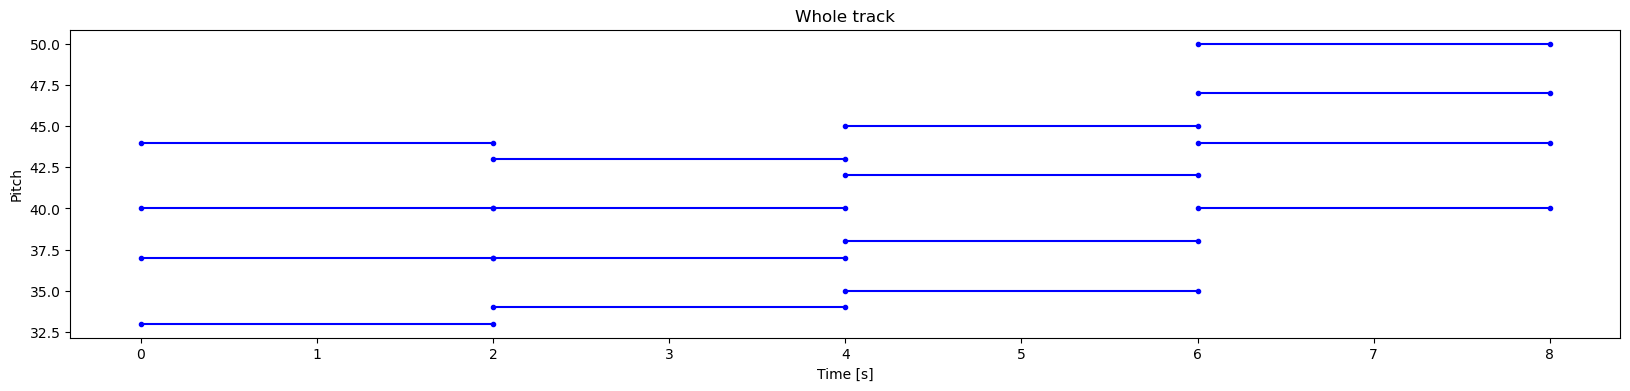

In [10]:
plot_piano_roll(raw_notes)

In [22]:
num_files = 1000
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
n_notes

16000

In [16]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
train_notes

array([[33.,  0.,  2.],
       [37.,  0.,  2.],
       [40.,  0.,  2.],
       ...,
       [83.,  0.,  2.],
       [86.,  0.,  2.],
       [88.,  0.,  2.]])

In [17]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [19]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                                drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [24]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [25]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [38]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  67584     ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_1[0][0]']              
                                                                                            

In [39]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [40]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
249/249 [==============================] - 21s 57ms/step - loss: 0.7856 - duration_loss: 0.0398 - pitch_loss: 3.7452 - step_loss: 0.5585
Epoch 2/50
249/249 [==============================] - 14s 56ms/step - loss: 0.4134 - duration_loss: 0.0031 - pitch_loss: 3.4925 - step_loss: 0.2357
Epoch 3/50
249/249 [==============================] - 14s 58ms/step - loss: 0.1636 - duration_loss: 5.9839e-04 - pitch_loss: 2.9331 - step_loss: 0.0164
Epoch 4/50
132/249 [==============>...............] - ETA: 6s - loss: 0.1204 - duration_loss: 3.6441e-04 - pitch_loss: 2.2854 - step_loss: 0.0058


KeyboardInterrupt



In [41]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

NameError: name 'history' is not defined